# **`--- IMPORTS ---`**

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important;}</style>"))
display(HTML("<style>div.output_scroll {height: 28em;}</style>"))
display(HTML("<style>.rendered_html {font-size: 16px;}</style>"))

C:\Users\Fran\AppData\Local\Temp\ipykernel_24488\1854931357.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import joblib
from datetime import datetime
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, classification_report, precision_score, recall_score, plot_confusion_matrix
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
import os

if os.path.basename(os.path.normpath(os.getcwd())) != 'streamlit-example':
    os.chdir('../')
    print('Changed path to "src" folder')    

Changed path to "src" folder


In [4]:
os.listdir()

['.git',
 '.gitignore',
 '.idea',
 'app',
 'data',
 'models',
 'notebooks',
 'README.md']

# **`--- READ DATA ---`**

In [5]:
accounts_train = pd.read_csv('data/accounts_train.csv')
quotes_train = pd.read_csv('data/quotes_train.csv')

accounts_test = pd.read_csv('data/accounts_test.csv')
quotes_test = pd.read_csv('data/quotes_test.csv')

In [6]:
print(accounts_train.shape)
display(accounts_train.head())

print(quotes_train.shape)
display(quotes_train.head())

(5709, 9)


,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees
0,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012.0,120000.0,50000.0,Limited Liability Company,4.0
1,85ec3b0c-8f89c-232b-6be4c-d033c5a52e,TX,Contractors,Electrical Contractors and Other Wiring Instal...,2012.0,60000.0,40000.0,Limited Liability Company,1.0
2,0fb1f276-95a95-9332-6927f-7e2dc3e610,NY,NaN,NaN,2016.0,150000.0,0.0,Corporation,0.0
3,5fe23456-f37a8-3c12-7a731-477f60edb9,CA,"Professional, Scientific and Technical Services",Architectural Services,2015.0,75000.0,55000.0,Limited Liability Company,0.0
4,2b2ceb23-20eb3-9a3c-87034-2eccac7276,AZ,Retail Trade,Tobacco Stores,2014.0,200000.0,0.0,Limited Liability Company,0.0


(11724, 5)


,account_uuid,product,premium,carrier_id,convert
0,f09e1383-2467-4741-9bd3-39cfd7a2b399,Business_Owners_Policy_BOP,4316.0,29,0
1,8e686305-a622-4f24-ba0a-478fcbbee32c,Commercial_Auto,2085.0,9,0
2,f13a4b1b-f1fe3-3e49-f60c2-824c38e79a,Business_Owners_Policy_BOP,607.0,60,0
3,8f58d58a-762b-40b2-8a9e-6adaa4c31ea5,Workers_Compensation,779.0,22,1
4,76eaf5b0-ed02d-3d49-15cf5-3745425c15,Workers_Compensation,10086.0,29,1


In [7]:
print(accounts_test.shape)
display(accounts_test.head())

print(quotes_test.shape)
display(quotes_test.head())

(2448, 9)


,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees
0,7c7089b9-30cc6-c5fc-9f5c8-1e4ce6a8c3,FL,"Technology, Media and Telecommunications",Software Publishers,2014.0,1200000.0,1000000.0,Corporation,11.0
1,bf68dd36-7dc94-0f5d-ebad4-19c0cdcdc7,TX,Administrative Services and Building Maintenance,Carpet and Upholstery Cleaning Services,2017.0,75000.0,1.0,Individual,0.0
2,fc97744d-9e9a-47a9-b923-1e2c3016c896,CA,Healthcare,Diagnostic Imaging Centers,2018.0,500000.0,70000.0,Limited Liability Company,3.0
3,0484a0e0-3c35e-0d2a-14c01-0220295202,CO,Consultants,Administrative Management and General Manageme...,2017.0,70000.0,0.0,Individual,0.0
4,673e8fb9-23833-3654-c6082-67470cfedb,AL,NaN,NaN,2017.0,156000.0,0.0,Other,0.0


(5005, 4)


,account_uuid,product,premium,carrier_id
0,cadb76f5-2f0ad-a78b-6c138-001288b999,Business_Owners_Policy_BOP,518.0,60
1,cadb76f5-2f0ad-a78b-6c138-001288b999,Business_Owners_Policy_BOP,542.0,60
2,d8aed557-aa49-4e6c-8f1d-860fa56e633f,General_Liability,500.0,39
3,08ec2c90-b3037-3f8e-429af-f834f19937,Business_Owners_Policy_BOP,500.0,31
4,14a4b644-740b-454e-8872-3460fda39092,CW_Professional_Liability,400.0,31


# **`--- PROCESS DATA ---`**

In [8]:
# -- ¿EXISTE ALGÚN REGISTRO DUPLICADO? --

accounts_train.duplicated().sum()

0

In [9]:
train = accounts_train.merge(quotes_train, how='left', on='account_uuid')
train

,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees,product,premium,carrier_id,convert
0,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012.0,120000.0,50000.0,Limited Liability Company,4.0,General_Liability,1177.0,39,0
1,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012.0,120000.0,50000.0,Limited Liability Company,4.0,General_Liability,1908.0,31,1
2,85ec3b0c-8f89c-232b-6be4c-d033c5a52e,TX,Contractors,Electrical Contractors and Other Wiring Instal...,2012.0,60000.0,40000.0,Limited Liability Company,1.0,Business_Owners_Policy_BOP,970.0,30,1
3,0fb1f276-95a95-9332-6927f-7e2dc3e610,NY,NaN,NaN,2016.0,150000.0,0.0,Corporation,0.0,General_Liability,816.0,31,1
4,5fe23456-f37a8-3c12-7a731-477f60edb9,CA,"Professional, Scientific and Technical Services",Architectural Services,2015.0,75000.0,55000.0,Limited Liability Company,0.0,CW_Inland_Marine,500.0,39,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11719,a068e7be-f6439-8d8b-2c28e-c137ab0bb8,OK,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2018.0,24000.0,0.0,Partnership,0.0,Business_Owners_Policy_BOP,475.0,30,0
11720,a068e7be-f6439-8d8b-2c28e-c137ab0bb8,OK,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2018.0,24000.0,0.0,Partnership,0.0,Business_Owners_Policy_BOP,600.0,39,0
11721,a068e7be-f6439-8d8b-2c28e-c137ab0bb8,OK,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2018.0,24000.0,0.0,Partnership,0.0,Business_Owners_Policy_BOP,500.0,60,0
11722,a068e7be-f6439-8d8b-2c28e-c137ab0bb8,OK,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2018.0,24000.0,0.0,Partnership,0.0,Business_Owners_Policy_BOP,500.0,60,0


In [10]:
# -- USERS CON MÁS TRANSACCIONES --

train['account_uuid'].value_counts(dropna=False).head(10)

c4748583-d523-4e8a-ab15-a5d3f20b10c6    29
da3d158b-7ce2-4b82-9fed-803f44323318    17
9b8c44ea-07902-4234-63cdd-4754d71527    16
8e01a3b0-ac57-418f-84bd-fab81df699d4    15
df65c541-40d4-4610-997d-b6703007daeb    14
40306000-a74f5-a9c7-bc993-59fcadfe16    13
33d056e9-3561-480a-8377-99ba7ce53aa8    13
e11b13c3-53ebb-ba34-17f72-ce7ad2445c    13
3635157b-cb27-4fac-b886-f29a1e0318c0    12
3f66f232-b7d9b-ab83-a113c-847dde9e76    12
Name: account_uuid, dtype: int64

In [11]:
train['account_value_by_product'] = train['premium']*train['convert']
train

,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees,product,premium,carrier_id,convert,account_value_by_product
0,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012.0,120000.0,50000.0,Limited Liability Company,4.0,General_Liability,1177.0,39,0,0.0
1,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012.0,120000.0,50000.0,Limited Liability Company,4.0,General_Liability,1908.0,31,1,1908.0
2,85ec3b0c-8f89c-232b-6be4c-d033c5a52e,TX,Contractors,Electrical Contractors and Other Wiring Instal...,2012.0,60000.0,40000.0,Limited Liability Company,1.0,Business_Owners_Policy_BOP,970.0,30,1,970.0
3,0fb1f276-95a95-9332-6927f-7e2dc3e610,NY,NaN,NaN,2016.0,150000.0,0.0,Corporation,0.0,General_Liability,816.0,31,1,816.0
4,5fe23456-f37a8-3c12-7a731-477f60edb9,CA,"Professional, Scientific and Technical Services",Architectural Services,2015.0,75000.0,55000.0,Limited Liability Company,0.0,CW_Inland_Marine,500.0,39,1,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11719,a068e7be-f6439-8d8b-2c28e-c137ab0bb8,OK,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2018.0,24000.0,0.0,Partnership,0.0,Business_Owners_Policy_BOP,475.0,30,0,0.0
11720,a068e7be-f6439-8d8b-2c28e-c137ab0bb8,OK,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2018.0,24000.0,0.0,Partnership,0.0,Business_Owners_Policy_BOP,600.0,39,0,0.0
11721,a068e7be-f6439-8d8b-2c28e-c137ab0bb8,OK,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2018.0,24000.0,0.0,Partnership,0.0,Business_Owners_Policy_BOP,500.0,60,0,0.0
11722,a068e7be-f6439-8d8b-2c28e-c137ab0bb8,OK,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2018.0,24000.0,0.0,Partnership,0.0,Business_Owners_Policy_BOP,500.0,60,0,0.0


In [12]:
train_account_values = train.groupby('account_uuid')['account_value_by_product'].sum().to_frame().rename(columns={'account_value_by_product': 'account_value'}).sort_values(by='account_value', ascending=False)
train_account_values

,account_value
account_uuid,
d567d1ae-cab98-0820-aed64-89090c2705,134752.41
1b3cadf5-01e2e-cb7b-22c3d-4879388a68,62111.00
87047ec6-4ef1c-73fe-a7c25-53b93d54c2,52382.00
e1613a34-eca2-4589-940d-e49fe339a25c,46333.00
7435711d-b8cf-4bd0-b04d-49f6ae48aee2,45745.00
...,...
358d734f-7f694-1437-93da3-b4a91f50c4,144.00
0d7e97d4-d7340-6a32-1e535-69cb6ffa69,127.00
3aedab18-3f4b6-1cba-fc75b-853ebcd04e,108.00


In [13]:
# -- MIRAMOS CUÁL ES EL USER CON MAYOR account_value --

train[train.account_uuid == "d567d1ae-cab98-0820-aed64-89090c2705"]

,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees,product,premium,carrier_id,convert,account_value_by_product
11166,d567d1ae-cab98-0820-aed64-89090c2705,NaN,Transportation and Warehousing,"General Freight Trucking, Local",NaN,75000000.0,NaN,Not sure yet,NaN,General_Liability,75508.00,39,1,75508.00
11167,d567d1ae-cab98-0820-aed64-89090c2705,NaN,Transportation and Warehousing,"General Freight Trucking, Local",NaN,75000000.0,NaN,Not sure yet,NaN,CW_Umbrella_Policy,20332.00,39,1,20332.00
11168,d567d1ae-cab98-0820-aed64-89090c2705,NaN,Transportation and Warehousing,"General Freight Trucking, Local",NaN,75000000.0,NaN,Not sure yet,NaN,CW_Employment_Practices_Liability_Insurance_EPLI,14787.00,73,0,0.00
11169,d567d1ae-cab98-0820-aed64-89090c2705,NaN,Transportation and Warehousing,"General Freight Trucking, Local",NaN,75000000.0,NaN,Not sure yet,NaN,CW_Employment_Practices_Liability_Insurance_EPLI,9682.00,31,0,0.00
11170,d567d1ae-cab98-0820-aed64-89090c2705,NaN,Transportation and Warehousing,"General Freight Trucking, Local",NaN,75000000.0,NaN,Not sure yet,NaN,CW_Inland_Marine,500.00,39,1,500.00
11171,d567d1ae-cab98-0820-aed64-89090c2705,NaN,Transportation and Warehousing,"General Freight Trucking, Local",NaN,75000000.0,NaN,Not sure yet,NaN,Commercial_Auto,17430.56,53,1,17430.56
11172,d567d1ae-cab98-0820-aed64-89090c2705,NaN,Transportation and Warehousing,"General Freight Trucking, Local",NaN,75000000.0,NaN,Not sure yet,NaN,Commercial_Auto,27644.56,53,0,0.00
11173,d567d1ae-cab98-0820-aed64-89090c2705,NaN,Transportation and Warehousing,"General Freight Trucking, Local",NaN,75000000.0,NaN,Not sure yet,NaN,CW_Employment_Practices_Liability_Insurance_EPLI,20981.85,73,1,20981.85


In [14]:
train = train.drop(columns='account_value_by_product').merge(train_account_values, how='left', on='account_uuid')
train

,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees,product,premium,carrier_id,convert,account_value
0,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012.0,120000.0,50000.0,Limited Liability Company,4.0,General_Liability,1177.0,39,0,1908.0
1,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012.0,120000.0,50000.0,Limited Liability Company,4.0,General_Liability,1908.0,31,1,1908.0
2,85ec3b0c-8f89c-232b-6be4c-d033c5a52e,TX,Contractors,Electrical Contractors and Other Wiring Instal...,2012.0,60000.0,40000.0,Limited Liability Company,1.0,Business_Owners_Policy_BOP,970.0,30,1,970.0
3,0fb1f276-95a95-9332-6927f-7e2dc3e610,NY,NaN,NaN,2016.0,150000.0,0.0,Corporation,0.0,General_Liability,816.0,31,1,816.0
4,5fe23456-f37a8-3c12-7a731-477f60edb9,CA,"Professional, Scientific and Technical Services",Architectural Services,2015.0,75000.0,55000.0,Limited Liability Company,0.0,CW_Inland_Marine,500.0,39,1,2040.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11719,a068e7be-f6439-8d8b-2c28e-c137ab0bb8,OK,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2018.0,24000.0,0.0,Partnership,0.0,Business_Owners_Policy_BOP,475.0,30,0,350.0
11720,a068e7be-f6439-8d8b-2c28e-c137ab0bb8,OK,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2018.0,24000.0,0.0,Partnership,0.0,Business_Owners_Policy_BOP,600.0,39,0,350.0
11721,a068e7be-f6439-8d8b-2c28e-c137ab0bb8,OK,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2018.0,24000.0,0.0,Partnership,0.0,Business_Owners_Policy_BOP,500.0,60,0,350.0
11722,a068e7be-f6439-8d8b-2c28e-c137ab0bb8,OK,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2018.0,24000.0,0.0,Partnership,0.0,Business_Owners_Policy_BOP,500.0,60,0,350.0


# **`--- EDA ---`**

In [15]:
train

,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees,product,premium,carrier_id,convert,account_value
0,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012.0,120000.0,50000.0,Limited Liability Company,4.0,General_Liability,1177.0,39,0,1908.0
1,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012.0,120000.0,50000.0,Limited Liability Company,4.0,General_Liability,1908.0,31,1,1908.0
2,85ec3b0c-8f89c-232b-6be4c-d033c5a52e,TX,Contractors,Electrical Contractors and Other Wiring Instal...,2012.0,60000.0,40000.0,Limited Liability Company,1.0,Business_Owners_Policy_BOP,970.0,30,1,970.0
3,0fb1f276-95a95-9332-6927f-7e2dc3e610,NY,NaN,NaN,2016.0,150000.0,0.0,Corporation,0.0,General_Liability,816.0,31,1,816.0
4,5fe23456-f37a8-3c12-7a731-477f60edb9,CA,"Professional, Scientific and Technical Services",Architectural Services,2015.0,75000.0,55000.0,Limited Liability Company,0.0,CW_Inland_Marine,500.0,39,1,2040.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11719,a068e7be-f6439-8d8b-2c28e-c137ab0bb8,OK,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2018.0,24000.0,0.0,Partnership,0.0,Business_Owners_Policy_BOP,475.0,30,0,350.0
11720,a068e7be-f6439-8d8b-2c28e-c137ab0bb8,OK,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2018.0,24000.0,0.0,Partnership,0.0,Business_Owners_Policy_BOP,600.0,39,0,350.0
11721,a068e7be-f6439-8d8b-2c28e-c137ab0bb8,OK,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2018.0,24000.0,0.0,Partnership,0.0,Business_Owners_Policy_BOP,500.0,60,0,350.0
11722,a068e7be-f6439-8d8b-2c28e-c137ab0bb8,OK,Retail Trade,"Cosmetics, Beauty Supplies, and Perfume Stores",2018.0,24000.0,0.0,Partnership,0.0,Business_Owners_Policy_BOP,500.0,60,0,350.0


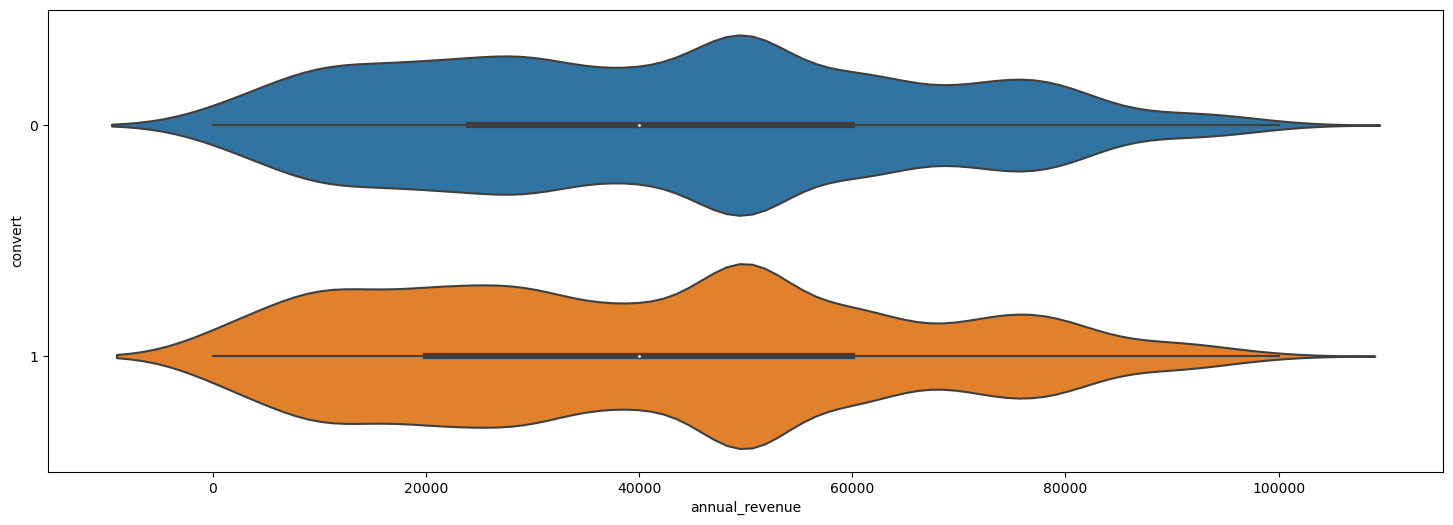

In [16]:
x = 'annual_revenue'

plt.figure(figsize=(18, 6))
sns.violinplot(data=train[train[x] < 1e5], y='convert', x=x, orient='h')
plt.show()

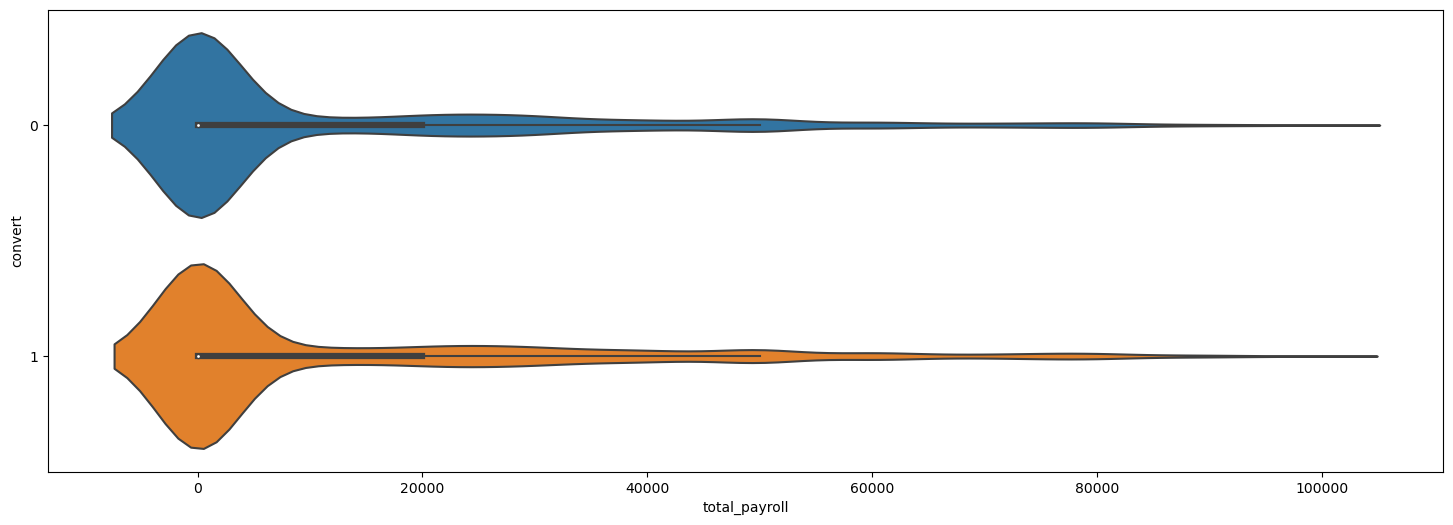

In [17]:
x = 'total_payroll'

plt.figure(figsize=(18, 6))
sns.violinplot(data=train[train[x] < 1e5], y='convert', x=x, orient='h')
plt.show()

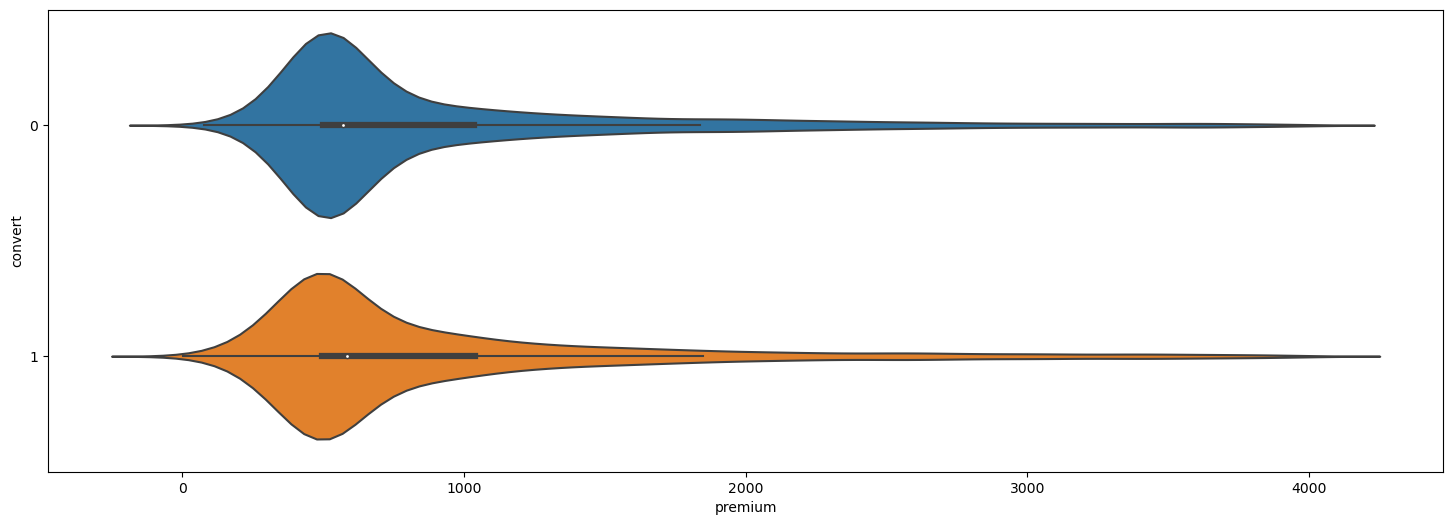

In [18]:
x = 'premium'

plt.figure(figsize=(18, 6))
sns.violinplot(data=train[train[x] < 4000], y='convert', x=x, orient='h')
plt.show()

# **`--- FIRST MODEL ---`**

In [19]:
df = train.copy()
df.sort_values(by='account_uuid', inplace=True)

In [20]:
df['convert'].value_counts(dropna=False)

1    6797
0    4927
Name: convert, dtype: int64

## **Feature selection**

In [21]:
target = 'convert'
# cols_to_drop = [target] + ['account_value']
cols_to_drop = [target] + ['account_uuid', 'account_value']

features = df.drop(columns=cols_to_drop).columns.tolist()
features

['state',
 'industry',
 'subindustry',
 'year_established',
 'annual_revenue',
 'total_payroll',
 'business_structure',
 'num_employees',
 'product',
 'premium',
 'carrier_id']

In [22]:
# -- PORCENTAJE DE NaN VALUES. DE MOMENTO LOS ELIMINAMOS --

print(100*df.isna().sum()/df.shape[0])
df.dropna(inplace=True)

account_uuid          0.000000
state                 0.332651
industry              2.055612
subindustry           2.055612
year_established      0.605595
annual_revenue        0.426476
total_payroll         0.784715
business_structure    0.017059
num_employees         0.725009
product               0.000000
premium               0.000000
carrier_id            0.000000
convert               0.000000
account_value         0.000000
dtype: float64


In [23]:
X = df[features]
Y = df[target]

print(X.shape)

(11402, 11)


In [24]:
# -- CATEGORICAL FEATURES -- 

X.select_dtypes(include='object').head()

,state,industry,subindustry,business_structure,product
11500,GA,Manufacturing,Malt Manufacturing,Limited Liability Company,General_Liability
11501,GA,Manufacturing,Malt Manufacturing,Limited Liability Company,Workers_Compensation
11502,GA,Manufacturing,Malt Manufacturing,Limited Liability Company,Business_Owners_Policy_BOP
11503,GA,Manufacturing,Malt Manufacturing,Limited Liability Company,Workers_Compensation
9087,VA,"Professional, Scientific and Technical Services","All Other Professional, Scientific, and Techni...",Limited Liability Company,Business_Owners_Policy_BOP


In [25]:
# -- TENEMOS MUCHA GRANULARIDAD EN LAS VARIABLES CATEGÓRICAS --

[X[col].nunique() for col in X.select_dtypes(include='object').columns]

[50, 21, 482, 9, 33]

## **Train/Test Split**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=False)  # shuffle=False para mantener el orden, de manera que un account_uuid esté a la vez en train y en test

In [27]:
cat_features = X.select_dtypes(include='object').columns.tolist()
cat_features

['state', 'industry', 'subindustry', 'business_structure', 'product']

In [28]:
clf = CatBoostClassifier()

clf.fit(X_train,
        y_train,
        cat_features=cat_features,
        eval_set=(X_test, y_test),
        verbose=False)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{}


In [29]:
import os 
os.listdir()

['.git',
 '.gitignore',
 '.idea',
 'app',
 'catboost_info',
 'data',
 'models',
 'notebooks',
 'README.md']

In [30]:
model_tag = 'catboost'
model_date = datetime.now().strftime("%Y%m%d_%Hh%Mm")
model_name = model_tag + '_' + model_date

joblib.dump(clf, f"models/{model_name}.joblib") 

['models/catboost_20221024_18h03m.joblib']

In [31]:
y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

y_pred_proba_test = clf.predict_proba(X_test)
y_pred_proba_train = clf.predict_proba(X_train)

In [32]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6832690284110838


## **Metrics**

### Feature importances

In [33]:
n_features = 10

importances = clf.feature_importances_[0:n_features]
indices = np.argsort(importances)[::-1][0:n_features]
names = [X_train.columns[i] for i in indices][0:n_features]

plt.figure(figsize=(10, 10))
plt.title("Feature Importance - Top {} features".format(n_features))
plt.barh(range(n_features), importances[indices])
plt.yticks(range(n_features), names, rotation=0)
plt.show()

NameError: name 'np' is not defined

### Confussion matrix

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_norm = conf_matrix / conf_matrix.astype(float).sum(axis=1)

ax = plt.subplot()
sns.heatmap(conf_matrix_norm, annot=True, cmap='Blues', fmt='g', ax=ax)

ax.set_xlabel('Convert - Predicted labels')
ax.set_ylabel('Convert - True labels')
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.title('Normalized Confusion Matrix')
plt.show()

ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', ax=ax)

ax.set_xlabel('Convert - Predicted labels')
ax.set_ylabel('Convert - True labels')
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

### ROC curve

In [ ]:
y_scores = y_pred_proba_test[:, 1]
# y_test_int = np.array((y_test == 'En Firme').astype(int)[target].tolist())

In [ ]:
# fpr, tpr, thresholds = roc_curve(y_test_int, y_scores) 
fpr, tpr, thresholds = roc_curve(y_test, y_scores) 

In [ ]:
AUC = auc(fpr, tpr) 
print('AUC: ' + str(AUC))

In [ ]:
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')')
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate') 
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()  

### Precision-Recall curve

In [ ]:
prec, recall, thresholds = precision_recall_curve(y_test, y_scores)
# prec, recall, thresholds = precision_recall_curve(y_test_int, y_scores)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(thresholds, recall[:-1], 'b--', linewidth=3, label='Recall')
ax1.set_xlabel('Threshold', fontsize=15)
ax1.set_ylabel('Recall', fontsize=15)
ax1.set_ylim([0, 1.15])
# ax1.axhline(0.1, color='r')
ax1.legend(loc="upper left", fontsize=15)

ax2 = ax1.twinx()  
ax2.plot(thresholds, prec[:-1], 'g--', linewidth=3, label = 'Precision')
ax2.set_xlabel('Threshold', fontsize=20)
ax2.set_ylabel('Precision', fontsize=15)
ax2.set_ylim([0, 1.15])
ax2.legend(loc="upper right", fontsize=15)

ax1.grid()
ax1.set_title("Precision -vs- Recall Tradeoff", fontsize=20)

plt.axvline(x=0.5, c='red')

plt.show()

# **`--- CALCULATE ACCOUNT_VALUE ---`**

In [ ]:
df_results = X_test.copy()
df_results['convert'] = y_test
df_results['convert_pred'] = y_pred
df_results['account_uuid'] = train.iloc[df_results.index]['account_uuid'].values
df_results

In [ ]:
df_results['account_value_by_product'] = df_results['premium']*df_results['convert']
df_results['account_value_by_product_pred'] = df_results['premium']*df_results['convert_pred']
df_results

In [ ]:
actual_account_values = df_results.groupby('account_uuid')['account_value_by_product'].sum().to_frame().rename(columns={'account_value_by_product': 'account_value_actual'}).sort_values(by='account_value_actual', ascending=False)
pred_account_values = df_results.groupby('account_uuid')['account_value_by_product_pred'].sum().to_frame().rename(columns={'account_value_by_product_pred': 'account_value_pred'}).sort_values(by='account_value_pred', ascending=False)

In [ ]:
account_values = actual_account_values.join(pred_account_values).reset_index()
account_values['res'] = account_values['account_value_actual'] - account_values['account_value_pred']
account_values

In [ ]:
rmse = mean_squared_error(account_values.account_value_actual, account_values.account_value_pred, squared=False)
rmse

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(account_values['res'], '.')
plt.show()

In [ ]:
df_results[df_results.account_uuid.isin(account_values[account_values.res < -40000].account_uuid.tolist())]